
# Análisis de Secuencias Nucleotídicas de Integronas de Shewanella

Este cuaderno realiza la descarga y análisis de secuencias nucleotídicas de integronas de Shewanella utilizando Biopython.


In [19]:
# @title Instalación de librerias
import subprocess
import ipywidgets as widgets
from IPython.display import display

def instalar_librerias(b=""):
    with output:
        librerias = [
            "import_ipynb",
            "nbconvert",
            "ipywidgets",  # Asegúrate de que ya esté instalado
            "biopython",
            "pandas",
            "numpy",
            "matplotlib",
            "tqdm",
            "odfpy",
            "requests",
            "gdown",
            "mafft",
            "clustalo",
            "muscle",
            "fasttree"
        ]

        barra_progreso = widgets.IntProgress(
            value=0,
            min=0,
            max=len(librerias),
            bar_style='info',
            orientation='horizontal'
        )

        etiqueta = widgets.Label(value='Iniciando instalación...')
        display(widgets.VBox([etiqueta, barra_progreso]))

        for libreria in librerias:
            etiqueta.value = f"Instalando: {libreria}..."
            subprocess.run(["pip", "install", libreria])
            barra_progreso.value += 1

        etiqueta.value = 'Instalación completada.'

# Crear botón
boton_instalar = widgets.Button(description='Instalar Librerías')

# Crear área de salida
output = widgets.Output()
display(output)
instalar_librerias()

Output()

In [20]:
def combinar_en_multifasta(rutas_archivos_fasta, archivo_multifasta):
    with open(archivo_multifasta, 'w') as archivo_salida:
        for ruta_fasta in rutas_archivos_fasta:
            with open(ruta_fasta, 'r') as archivo_entrada:
                archivo_salida.write(archivo_entrada.read() + "\n")

# Combina los archivos FASTA en un solo archivo multifasta
#archivo_multifasta = "secuencias_combinadas.fasta"
#combinar_en_multifasta(rutas_archivos_fasta, archivo_multifasta)


In [24]:
from Bio import SeqIO
from Bio.Align.Applications import MafftCommandline
import multiprocessing
from ipywidgets import IntProgress, VBox, Label
from IPython.display import display
import os
import time
import threading
from ipywidgets import Text

def dividir_archivo_multifasta(archivo_multifasta, num_secuencias_por_archivo):
    with open(archivo_multifasta, "r") as handle:
        secuencias = list(SeqIO.parse(handle, "fasta"))

    archivos_divididos = []
    for i in range(0, len(secuencias), num_secuencias_por_archivo):
        archivo_parte = f"parte_{i//num_secuencias_por_archivo}.fasta"
        with open(archivo_parte, "w") as output_handle:
            SeqIO.write(secuencias[i:i + num_secuencias_por_archivo], output_handle, "fasta")
        archivos_divididos.append(archivo_parte)

    return archivos_divididos

def alinear_con_mafft(archivo_fasta):
    archivo_salida = archivo_fasta.replace(".fasta", "_alineado.fasta")
    mafft_cline = MafftCommandline(input=archivo_fasta, auto=True)
    stdout, stderr = mafft_cline()
    with open(archivo_salida, "w") as output_handle:
        output_handle.write(stdout)
    return archivo_salida

def alinear_archivos_en_paralelo(archivos_divididos):
    pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())
    resultados = pool.map(alinear_con_mafft, archivos_divididos)
    pool.close()
    pool.join()
    return resultados

def mostrar_indicador_actividad(label, intervalo=5):
    global proceso_activo
    proceso_activo = True
    contador = 0
    while proceso_activo:
        time.sleep(intervalo)
        contador += intervalo
        if proceso_activo:
            label.value = f"El proceso sigue activo... {contador} segundos"

def alinear_secuencias(archivo_multifasta, num_secuencias_por_archivo):
    archivos_divididos = dividir_archivo_multifasta(archivo_multifasta, num_secuencias_por_archivo)

    # Inicializar barra de progreso e indicador de actividad
    progress_bar = IntProgress(min=0, max=len(archivos_divididos))
    progress_label = Label('Iniciando alineamiento...')
    activity_label = Text(value='El proceso ha comenzado.', disabled=True)
    display(VBox([progress_label, progress_bar, activity_label]))

    # Iniciar indicador de actividad
    hilo_indicador = threading.Thread(target=mostrar_indicador_actividad, args=(activity_label,))
    hilo_indicador.start()

    # Alineamiento en paralelo
    for i, _ in enumerate(alinear_archivos_en_paralelo(archivos_divididos), 1):
        progress_bar.value = i
        progress_label.value = f"Alineando archivo {i} de {len(archivos_divididos)}"

    # Finalizar indicador de actividad
    global proceso_activo
    proceso_activo = False
    hilo_indicador.join()

    progress_label.value = 'Alineamiento completado.'
    activity_label.value = 'Proceso finalizado.'

# Uso de la función
archivo_multifasta = "tu_archivo_combinado.fasta"  # Reemplaza con la ruta de tu archivo
num_secuencias_por_archivo = 100  # Ajusta según tus necesidades
#alinear_secuencias(archivo_multifasta, num_secuencias_por_archivo)



In [23]:
from Bio.Align.Applications import MafftCommandline
from Bio import AlignIO
from Bio import Phylo
from Bio.Phylo.Applications import FastTreeCommandline
import os
import subprocess

def construir_arbol_con_mafft(ruta_alineamiento):
    # Verificar si el archivo de alineamiento existe
    if not os.path.exists(ruta_alineamiento):
        print(f"El archivo {ruta_alineamiento} no existe.")
        return

    archivo_arbol = "arbol_mafft.nwk"

    try:
        # Ejecutar FastTree
        fasttree_cline = FastTreeCommandline(input=ruta_alineamiento, out=archivo_arbol)
        subprocess.run(str(fasttree_cline), shell=True, check=True)

        # Leer y dibujar el árbol
        arbol = Phylo.read(archivo_arbol, "newick")
        Phylo.draw(arbol)
    except Exception as e:
        print(f"Ocurrió un error al construir el árbol: {e}")

# Construcción del árbol
#construir_arbol_con_mafft("/content/parte_4_alineado.fasta")


In [25]:
!apt-get install fasttree


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fasttree
0 upgraded, 1 newly installed, 0 to remove and 15 not upgraded.
Need to get 174 kB of archives.
After this operation, 499 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fasttree amd64 2.1.11-2 [174 kB]
Fetched 174 kB in 1s (120 kB/s)
Selecting previously unselected package fasttree.
(Reading database ... 120882 files and directories currently installed.)
Preparing to unpack .../fasttree_2.1.11-2_amd64.deb ...
Unpacking fasttree (2.1.11-2) ...
Setting up fasttree (2.1.11-2) ...
Processing triggers for man-db (2.10.2-1) ...


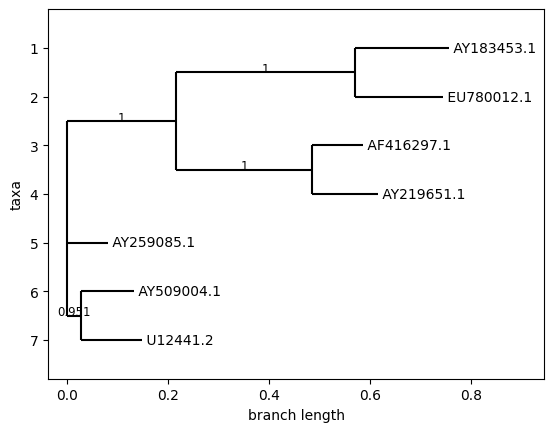

In [26]:
from Bio.Align.Applications import MafftCommandline
from Bio import AlignIO
from Bio import Phylo
from Bio.Phylo.Applications import FastTreeCommandline
import os
import subprocess

def construir_arbol_con_mafft(ruta_alineamiento):
    if not os.path.exists(ruta_alineamiento):
        print(f"El archivo {ruta_alineamiento} no existe.")
        return

    archivo_arbol = "arbol_mafft.nwk"

    try:
        # Ejecutar FastTree
        comando_fasttree = ["fasttree", "-out", archivo_arbol, ruta_alineamiento]
        subprocess.run(comando_fasttree, check=True)

        # Leer y dibujar el árbol
        arbol = Phylo.read(archivo_arbol, "newick")
        Phylo.draw(arbol)
    except Exception as e:
        print(f"Ocurrió un error al construir el árbol: {e}")

# Uso de la función
ruta_alineamiento = "/content/parte_0_alineado.fasta"  # Reemplaza con la ruta de tu archivo alineado
construir_arbol_con_mafft(ruta_alineamiento)



